In [ ]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    # ... add 1 more item
]

student busket


In [ ]:
#define the 'machine' (function)
def calculate_inflation(base,current):
  return ((current-base)/base)*100

# Run the Loop
for item in student_basket:
  rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
  print(f"{item['Item']}:{rate:.2f}% inflation")

Tuition:28.89% inflation
Rent (1 Bed):50.00% inflation
Chipotle Burrito:53.33% inflation


In [ ]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='028fd9da54d1d855f09c406251c30a7a')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
streaming    = fred.get_series('CUSR0000SERA02')  #  streaming TV
food_away    = fred.get_series('CUSR0000SEFV')    # Food away from home

# Added Rent
# ... fetch remaining series
 # Added Rent
# ... fetch remaining series

In [ ]:
import pandas as pd

# df_raw: 合并好的原始数据
df_raw = pd.DataFrame({
    "Official CPI": official_cpi,
    "Tuition": tuition,
    "Rent": rent,
    "Streaming": streaming,
    "Food Away": food_away
}).sort_index()

start = pd.Timestamp("2016-01-01")

base_date = df_raw.index[df_raw.index.get_indexer([start], method="ffill")[0]]


df_index = df_raw.div(df_raw.loc[base_date]).mul(100)

print("Base date used:", base_date.date())
df_index.loc[base_date]






Base date used: 2016-01-01


,2016-01-01
Official CPI,100.0
Tuition,100.0
Rent,100.0
Streaming,100.0
Food Away,100.0


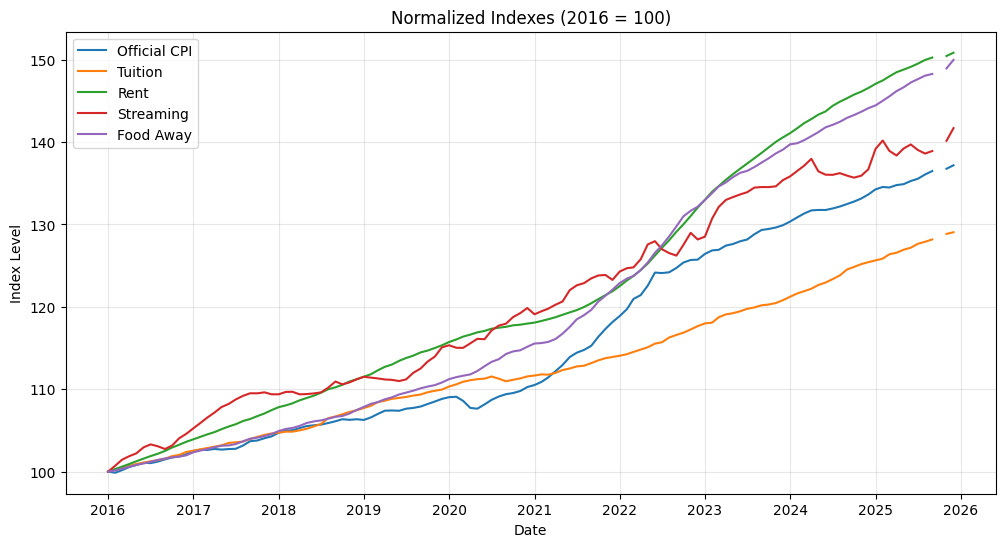

In [ ]:
import matplotlib.pyplot as plt

df_plot = df_index.loc["2016-01-01":].copy()

plt.figure(figsize=(12,6))
for col in df_plot.columns:
    plt.plot(df_plot.index, df_plot[col], label=col)

plt.title("Normalized Indexes (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


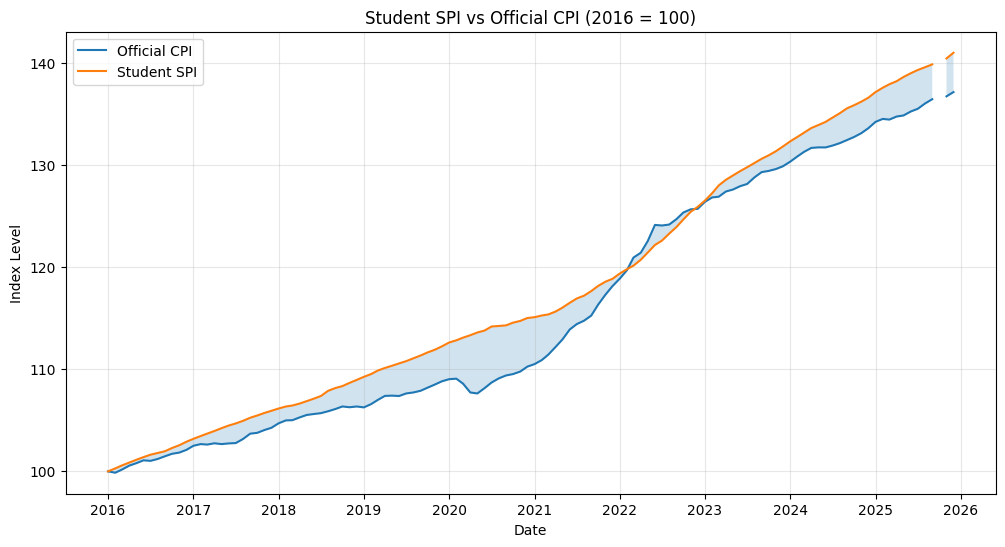

In [ ]:
import matplotlib.pyplot as plt

# 1) 只用2016以后数据
df_plot = df_index.loc["2016-01-01":].copy()

# 2) Define weights (总和=1)
weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Food Away": 0.20,
    "Streaming": 0.10
}

# 3) Weighted Student SPI
df_plot["Student_SPI"] = (
    df_plot["Tuition"]   * weights["Tuition"] +
    df_plot["Rent"]      * weights["Rent"] +
    df_plot["Food Away"] * weights["Food Away"] +
    df_plot["Streaming"] * weights["Streaming"]
)

# 4) Plot Student_SPI vs Official CPI
plt.figure(figsize=(12,6))
plt.plot(df_plot.index, df_plot["Official CPI"], label="Official CPI")
plt.plot(df_plot.index, df_plot["Student_SPI"], label="Student SPI")

# 5) Inflation Gap shading
plt.fill_between(
    df_plot.index,
    df_plot["Official CPI"],
    df_plot["Student_SPI"],
    alpha=0.2
)

plt.title("Student SPI vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


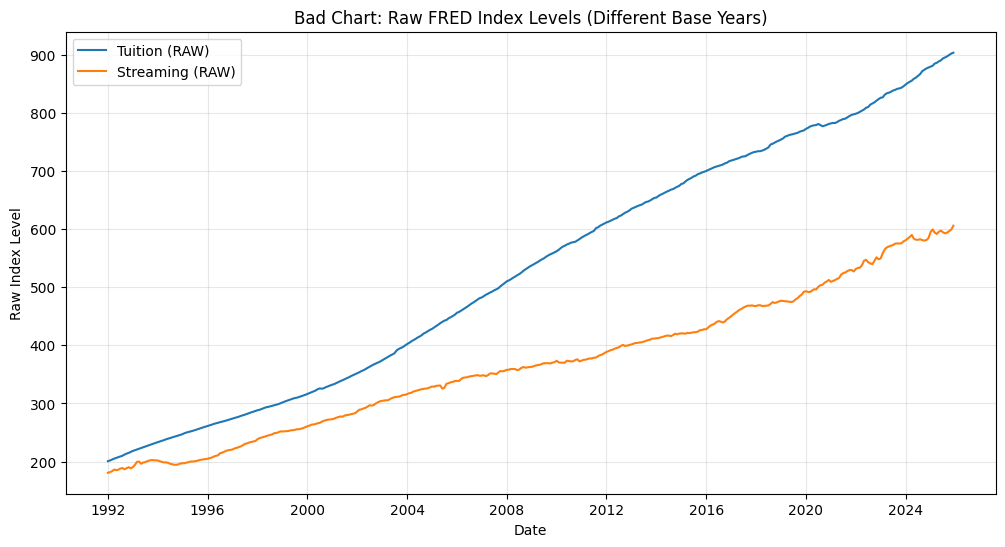

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_bad = pd.DataFrame({
    "Tuition (RAW)": tuition,
    "Streaming (RAW)": streaming
}).dropna()

plt.figure(figsize=(12,6))
plt.plot(df_bad.index, df_bad["Tuition (RAW)"], label="Tuition (RAW)")
plt.plot(df_bad.index, df_bad["Streaming (RAW)"], label="Streaming (RAW)")

plt.title("Bad Chart: Raw FRED Index Levels (Different Base Years)")
plt.xlabel("Date")
plt.ylabel("Raw Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Simple Explanation (Why we normalize):
Tuition and Streaming CPI use different base years in FRED.
So their raw index numbers are on different scales.
When we plot them together, Tuition looks very big and Streaming looks very small.
This is misleading and not a fair comparison.
To compare them correctly, we re-index both series to the same start date (2016 = 100).


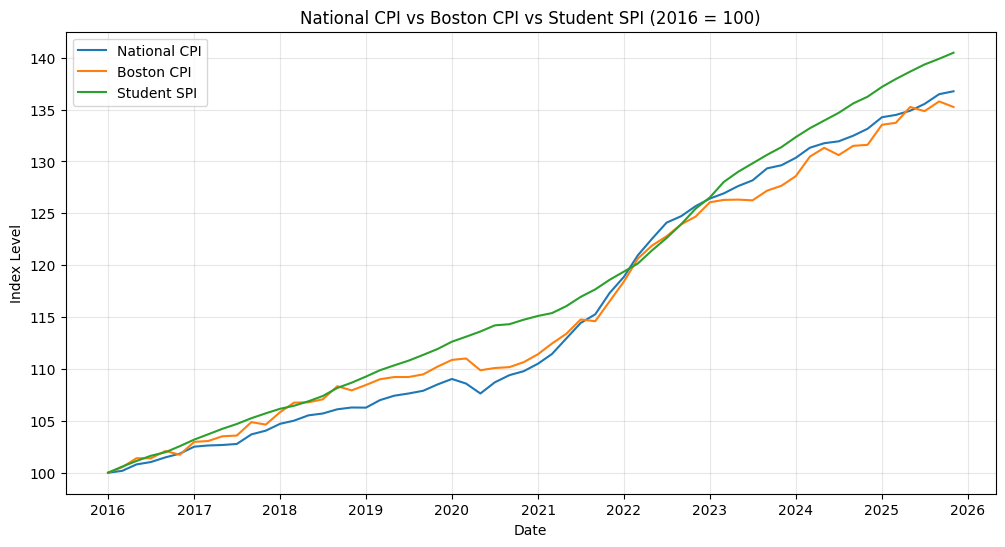

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Fetch Boston CPI series from FRED
boston_cpi_raw = fred.get_series("CUURA103SA0")

# 2) Put into DataFrame with your existing normalized series
df_compare = pd.DataFrame({
    "National CPI": df_index["Official CPI"],      # already normalized
    "Student SPI": df_plot["Student_SPI"],         # already normalized (from Step 3.2)
    "Boston CPI (RAW)": boston_cpi_raw
}).sort_index()

# 3) Re-index Boston CPI to 2016=100
base_date = pd.to_datetime("2016-01-01")
df_compare = df_compare.dropna(subset=["Boston CPI (RAW)"])

if base_date not in df_compare.index:
    base_date = df_compare.loc[:base_date].index[-1]

df_compare["Boston CPI"] = (df_compare["Boston CPI (RAW)"] / df_compare.loc[base_date, "Boston CPI (RAW)"]) * 100

# 4) Keep 2016+ for clean chart
df_compare_plot = df_compare.loc["2016-01-01":].copy()

# 5) Plot three lines
plt.figure(figsize=(12,6))
plt.plot(df_compare_plot.index, df_compare_plot["National CPI"], label="National CPI")
plt.plot(df_compare_plot.index, df_compare_plot["Boston CPI"], label="Boston CPI")
plt.plot(df_compare_plot.index, df_compare_plot["Student SPI"], label="Student SPI")

plt.title("National CPI vs Boston CPI vs Student SPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
